# Классификация изображений семян
Имеется:
*   Датасет ~2000 изображений семян (все не будут использованы)
*   Csv файл с разметкой на 3 класса (healthy, cracked, enzym)

Задачи:
*   Сделать разные виды предобработки изображений (без предобработки, ESRGAN, LDMSuperResolution) чтобы сравнить результаты
*   Сделать трехклассовую классификацию используя различные модели (VGG16, ResNet50, EfficientNet)



# Загрука данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
labels_df = pd.read_csv("/content/drive/MyDrive/Изображения/Разметка/train_table.csv")
labels_df.head()

,id,healthy,cracked,enzym
0,10,1,0,0
1,16,1,0,0
2,18,1,0,0
3,20,1,0,0
4,40,1,0,0


labels_df.shape[0] : 888
healthy: 164 
cracked: 389 
enzym: 335


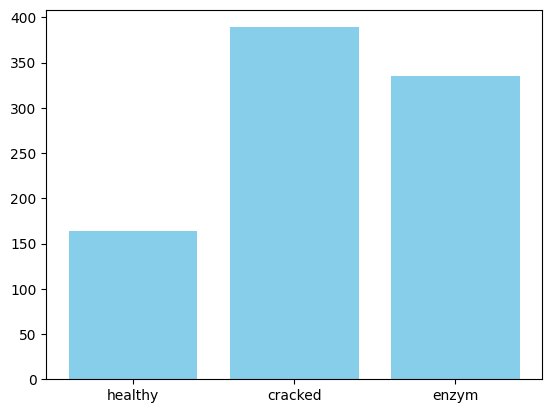

In [ ]:
imgpath ="/content/drive/MyDrive/Изображения/images_all"

healthy = labels_df.loc[labels_df['healthy']==1]['id'].values
cracked = labels_df.loc[labels_df['cracked']==1]['id'].values
enzym = labels_df.loc[labels_df['enzym']==1]['id'].values

print('labels_df.shape[0] :', labels_df.shape[0])
print('healthy:' , len(healthy), '\ncracked:' , len(cracked), '\nenzym:' , len(enzym))

categories = ['healthy', 'cracked', 'enzym']
values = [len(healthy), len(cracked), len(enzym)]

# Создание столбчатой диаграммы
plt.bar(categories, values, color='skyblue')
plt.show()

In [ ]:
import os
output_folder = "/content/drive/MyDrive/Изображения/img_all_sort/cracked"

In [ ]:
cracked1 = []
for i in range(164,553):
  cracked1.append(all_orig_imgs[i])

In [ ]:
for i, cracked1 in enumerate(cracked1):
    output_path = os.path.join(output_folder, f"cracked{i}.png")
    cracked1.save(output_path)

Анализ разметки:

* Всего размечено 888 изображений, из них : 164 - здоровые семена, 389 - с дефектом трещиноватость и 335 с деектом ЭМИС
* Данные несблансированны : снимков с трещиноватостью в 2 раза больше чем здоровых. Эту проблему решим аугментацией данных.

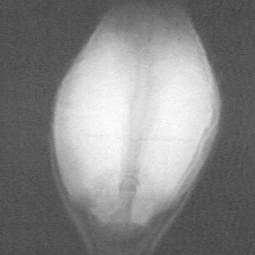

In [ ]:
all_orig_imgs[553]

In [ ]:
cracked1 = []
for i in range(164, 553):
  cracked1.append(all_orig_imgs[i])

In [ ]:
output_folder = "/content/drive/MyDrive/Изображения/cracked1"
for i, cracked1 in enumerate(cracked1):
    output_path = os.path.join(output_folder, f"cracked{i}.png")
    cracked1.save(output_path)

# Аугментация данных

Изображений в датасете немного, увеличим припомощи поворота снимков

"Здоровые" снимки увеличим в 3 раза (2 раза повернув (492 снимка))

In [ ]:
all_orig_imgs = []

for i in range(labels_df.shape[0]):
  fname = os.path.join(imgpath,'crop_img_'+ str(labels_df['id'].loc[labels_df.index[i]]) +'.png')
  img = Image.open(fname)

  orig_img = img.resize((255, 255))
  all_orig_imgs.append(orig_img)

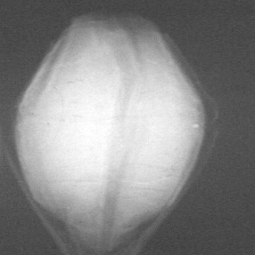

In [ ]:
all_orig_imgs[887]

In [ ]:
def rotate_image_with_background_fill(img, angle):
    # Открываем изображение
    original_image = img

    # Получаем размеры оригинального изображения
    width, height = original_image.size

    # Вычисляем размеры нового изображения после поворота
    new_width = int(abs(width * np.cos(np.radians(angle))) + abs(height * np.sin(np.radians(angle))))
    new_height = int(abs(height * np.cos(np.radians(angle))) + abs(width * np.sin(np.radians(angle))))

    # Создаем новое изображение с фоном того же цвета, что и исходное изображение
    background_color = original_image.getpixel((0, 0))  # Получаем цвет пикселя в левом верхнем углу
    new_image = Image.new("L", (new_width, new_height), background_color)

    # Поворачиваем оригинальное изображение
    rotated_image = original_image.rotate(angle, expand=True)

    # Вычисляем координаты для центрирования оригинального изображения в новом
    x_offset = (new_width - rotated_image.width) // 2
    y_offset = (new_height - rotated_image.height) // 2

    # Вставляем повёрнутое изображение в новое изображение
    new_image.paste(rotated_image, (x_offset, y_offset), rotated_image)
    new_image = new_image.resize((255,255))

    return new_image


492


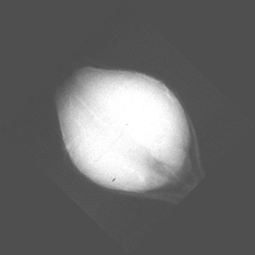

In [ ]:
import random
aug_health_img = []

for i in range(len(healthy)):
  aug_health_img.append(all_orig_imgs[i])
  angle = random.randint(30, 60)
  augmented_image = rotate_image_with_background_fill(all_orig_imgs[i], angle)
  aug_health_img.append(augmented_image)
  angle = random.randint(90, 150)
  augmented_image = rotate_image_with_background_fill(all_orig_imgs[i], angle)
  aug_health_img.append(augmented_image)

print(len(aug_health_img))
aug_health_img[1]

501


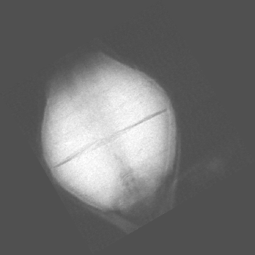

In [ ]:
aug_cracked_img = []

for i in range(len(healthy), round((len(healthy) + len(cracked))/2)):
  angle = random.randint(30, 60)
  augmented_image = rotate_image_with_background_fill(all_orig_imgs[i], angle)
  aug_cracked_img.append(augmented_image)

for i in range(len(healthy), len(healthy) + len(cracked)):
  aug_cracked_img.append(all_orig_imgs[i])

print(len(aug_cracked_img))
aug_cracked_img[1]

502


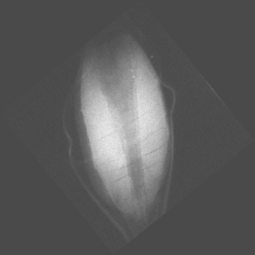

In [ ]:
aug_enzym_img = []

for i in range(len(all_orig_imgs)- len(enzym), 720):
  #aug_cracked_img.append(all_orig_imgs[i])
  angle = random.randint(30, 60)
  augmented_image = rotate_image_with_background_fill(all_orig_imgs[i], angle)
  aug_enzym_img.append(augmented_image)

for i in range(len(all_orig_imgs)- len(enzym), len(all_orig_imgs)):
  aug_enzym_img.append(all_orig_imgs[i])

print(len(aug_enzym_img))
aug_enzym_img[70]

1495


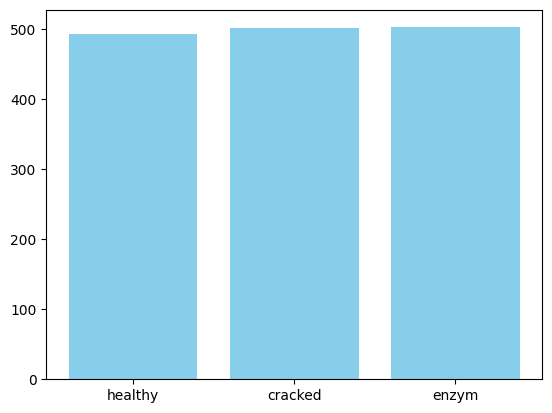

In [ ]:
all_aug_img = []

print(len(aug_health_img) + len(aug_cracked_img)+ len(aug_enzym_img))
categories = ['healthy', 'cracked', 'enzym']
values = [len(aug_health_img), len(aug_cracked_img), len(aug_enzym_img)]

# Создание столбчатой диаграммы
plt.bar(categories, values, color='skyblue')
plt.show()

In [ ]:
import os

output_folder = "/content/drive/MyDrive/Изображения/all_aug_img/enzyme"

for i, aug_enzym_img in enumerate(aug_enzym_img):
    output_path = os.path.join(output_folder, f"enzyme{i}.png")
    aug_enzym_img.save(output_path)

output_folder = "/content/drive/MyDrive/Изображения/all_aug_img/cracked"
for i, aug_cracked_img in enumerate(aug_cracked_img):
    output_path = os.path.join(output_folder, f"cracked{i}.png")
    aug_cracked_img.save(output_path)

output_folder = "/content/drive/MyDrive/Изображения/all_aug_img/healthy"
for i, aug_health_img in enumerate(aug_health_img):
    output_path = os.path.join(output_folder, f"health{i}.png")
    aug_health_img.save(output_path)

# Предобрабока

Будут сделаны 3 варианта: без предобработки, контраст, LDMSuperResolution


In [ ]:
import numpy as np
import cv2 as cv

img = cv.imread('/content/drive/MyDrive/Изображения/all_aug_img/cracked/cracked0.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

cv.imwrite('clahe_2.jpg',cl1)

True

In [ ]:
import cv2 as cv
imgpath = '/content/drive/MyDrive/Изображения/all_aug_img'
# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [ ]:
CLANE_healthy_img = []

for i in range(len(aug_health_img)):
  fname = os.path.join(imgpath,'crop_img_'+ str(labels_df['id'].loc[labels_df.index[i]]) +'.png')
  img = cv.imread( , cv.IMREAD_GRAYSCALE)
  cl = clahe.apply(img)
  aug_cracked_img.append(augmented_image)

for i in range(len(healthy), len(healthy) + len(cracked)):
  aug_cracked_img.append(all_orig_imgs[i])

print(len(aug_cracked_img))
aug_cracked_img[1]

array([[75, 75, 75, ..., 75, 75, 75],
       [75, 75, 75, ..., 75, 75, 75],
       [75, 75, 75, ..., 75, 75, 75],
       ...,
       [75, 75, 75, ..., 75, 75, 75],
       [75, 75, 75, ..., 75, 75, 75],
       [75, 75, 75, ..., 75, 75, 75]], dtype=uint8)
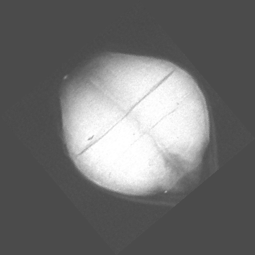

In [ ]:
img

array([[78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78],
       ...,
       [78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78]], dtype=uint8)
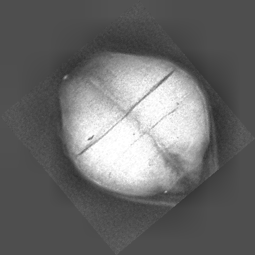

In [ ]:
cl1

In [ ]:
#Модели скрытой диффузии (LDM) для сверхразрешения подгружаем
!pip install git+https://github.com/huggingface/diffusers.git

from diffusers import LDMSuperResolutionPipeline

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-xx5g6d_9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-xx5g6d_9
  Resolved https://github.com/huggingface/diffusers.git to commit 100142586f82a9410f5bc393b9eb06c12d771006
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.33.0.dev0-py3-none-any.whl size=3492582 sha256=7b197c9d2ba2655fb29475c53ad5fc1c2eecb77dabd9e08ef9f1bdfd0f070b12
  Stored in directory: /tmp/pip-ephem-wheel-cache-bb__9an9/wheels/d2/5c/5f/16639722ea17ecb73ab461b81718584bac08af2801619786b9
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.32.2
    Uninstalling diffusers-0.32.2:
      Successfully uninstalled diffusers-0.32.2


In [ ]:
model_id = "CompVis/ldm-super-resolution-4x-openimages"

In [ ]:
# load model and scheduler
pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


OSError: Error no file named diffusion_pytorch_model.bin found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.

In [ ]:
health_sr_imgs = []
for img in aug_health_img:
  # run pipeline in inference (sample random noise and denoise)
  upscaled_image = pipeline(img, num_inference_steps=100, eta=1).images[0]
  health_sr_imgs.append(upscaled_image)

# Деление на train и validation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
data_dir ="/content/drive/MyDrive/Изображения/all_aug_img"

In [ ]:
img_height, img_width = 255, 255
batch_size = 16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1495 files belonging to 3 classes.
Using 1196 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1495 files belonging to 3 classes.
Using 299 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['cracked', 'enzyme', 'healthy']

In [ ]:
import matplotlib.pyplot as plt

# Обучение модели

В качесте моделей классификации попробую:
ResNet50, VGG19, MobileNet

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrap

#ResNet50

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(255,255,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 3)                 1539      
 apper)                                                          
                                                                 
Total params: 24638339 (93.99 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

In [ ]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 407s 5s/step - loss: 0.7449 - accuracy: 0.7391 - val_loss: 0.4677 - val_accuracy: 0.8261
Epoch 2/10
75/75 [==============================] - 383s 5s/step - loss: 0.3402 - accuracy: 0.8671 - val_loss: 0.4746 - val_accuracy: 0.8027
Epoch 3/10
75/75 [==============================] - 397s 5s/step - loss: 0.3483 - accuracy: 0.8637 - val_loss: 0.4863 - val_accuracy: 0.8294
Epoch 4/10
75/75 [==============================] - 397s 5s/step - loss: 0.2656 - accuracy: 0.8972 - val_loss: 0.5175 - val_accuracy: 0.8127
Epoch 5/10
75/75 [==============================] - 398s 5s/step - loss: 0.1789 - accuracy: 0.9339 - val_loss: 0.3478 - val_accuracy: 0.8763
Epoch 6/10
75/75 [==============================] - 400s 5s/step - loss: 0.1616 - accuracy: 0.9423 - val_loss: 0.3868 - val_accuracy: 0.8528
Epoch 7/10
75/75 [==============================] - 392s 5s/step - loss: 0.1856 - accuracy: 0.9239 - val_loss: 0.3648 - val_accuracy: 0.8528
Epoch 8/10
75

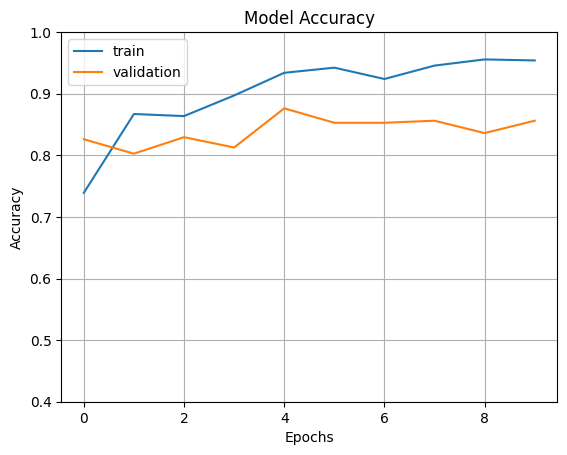

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

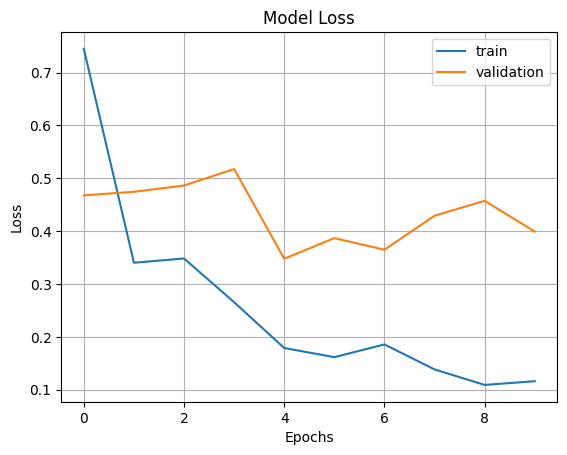

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#VGG16

In [ ]:
resnet_model_VGG16 = Sequential()

pretrained_model= tf.keras.applications.VGG16(
                   include_top=False,
                   input_shape=(255,255,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model_VGG16.add(pretrained_model)
resnet_model_VGG16.add(Flatten())
resnet_model_VGG16.add(Dense(128, activation='relu'))
resnet_model_VGG16.add(Dense(3, activation='softmax'))

In [ ]:
resnet_model_VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 512)               0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 128)               65664     
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 3)                 387       
 apper)                                                          
                                                                 
Total params: 14780739 (56.38 MB)
Trainable params: 66051 (258.01 KB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
resnet_model_VGG16.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=3
history = resnet_model_VGG16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
75/75 [==============================] - 1208s 16s/step - loss: 0.5727 - accuracy: 0.7801 - val_loss: 0.4894 - val_accuracy: 0.8328
Epoch 2/3
75/75 [==============================] - 1156s 15s/step - loss: 0.2495 - accuracy: 0.9013 - val_loss: 0.3497 - val_accuracy: 0.8896
Epoch 3/3
75/75 [==============================] - 1167s 16s/step - loss: 0.1840 - accuracy: 0.9214 - val_loss: 0.3295 - val_accuracy: 0.9164


In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#EfficientNet

In [ ]:
efficientnet_model = Sequential()

# Загружаем предобученную EfficientNetB0
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(255, 255, 3),  # Размер изображений 255x255
    weights='imagenet',
    pooling='avg'  # Используем Global Average Pooling
)

# Замораживаем веса предобученной модели
for layer in pretrained_model.layers:
    layer.trainable = False

# Добавляем EfficientNet в нашу модель
efficientnet_model.add(pretrained_model)

# Добавляем свои слои
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dense(3, activation='softmax'))  # 3 класса на выходе

# Компилируем модель
efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Выводим информацию о модели
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 module_wrapper (ModuleWrap  (None, 1280)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 128)               163968    
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 3)                 387       
 apper)                                                          
                                                                 
Total params: 4213926 (16.07 MB)
Trainable params: 16435

In [ ]:
epochs=3
history = efficientnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
75/75 [==============================] - 226s 3s/step - loss: 0.5138 - accuracy: 0.7893 - val_loss: 0.3609 - val_accuracy: 0.8595
Epoch 2/3
75/75 [==============================] - 157s 2s/step - loss: 0.2868 - accuracy: 0.8888 - val_loss: 0.3182 - val_accuracy: 0.8696
Epoch 3/3
75/75 [==============================] - 148s 2s/step - loss: 0.2475 - accuracy: 0.8997 - val_loss: 0.2761 - val_accuracy: 0.8930


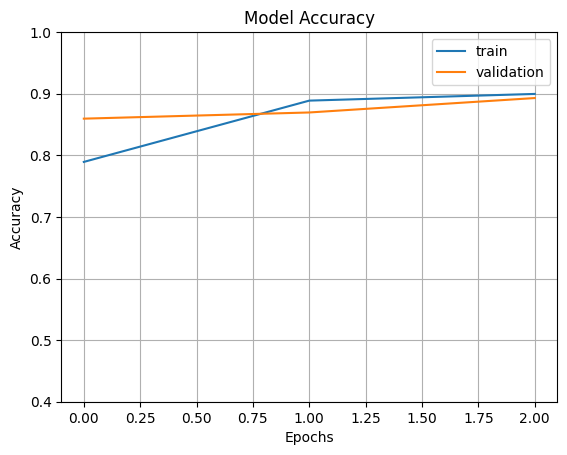

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

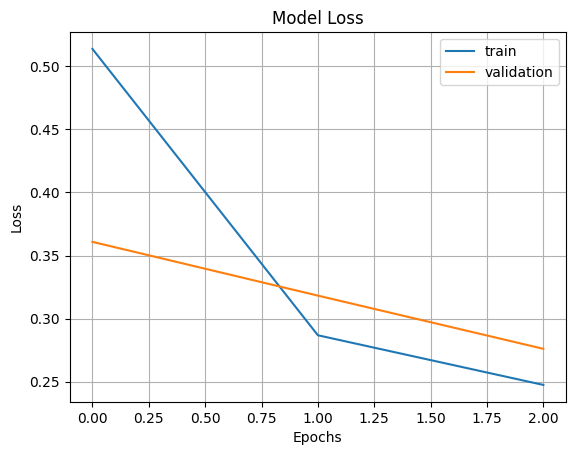

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#ResNet50 Без аугментации 224

In [ ]:
data_dir ="/content/drive/MyDrive/Изображения/img_all_sort"

img_height, img_width = 224, 224
batch_size = 16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 711 files for training.
Found 888 files belonging to 3 classes.
Using 177 files for validation.


In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

resnet_model.summary()
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=[keras.metrics.AUC()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 512)               1049088   
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 3)                 1539      
 apper)                                                          
                                                                 
Total params: 24638339 (93.99 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

recall

In [ ]:
#recall
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
45/45 [==============================] - 202s 4s/step - loss: 0.8665 - recall: 0.6582 - val_loss: 0.5615 - val_recall: 0.7853
Epoch 2/5
45/45 [==============================] - 149s 3s/step - loss: 0.3532 - recall: 0.8594 - val_loss: 0.3305 - val_recall: 0.8701
Epoch 3/5
45/45 [==============================] - 154s 3s/step - loss: 0.2490 - recall: 0.8945 - val_loss: 0.3274 - val_recall: 0.8814
Epoch 4/5
45/45 [==============================] - 160s 4s/step - loss: 0.2086 - recall: 0.9170 - val_loss: 0.3093 - val_recall: 0.8644
Epoch 5/5
45/45 [==============================] - 163s 4s/step - loss: 0.2145 - recall: 0.9086 - val_loss: 0.2992 - val_recall: 0.9040


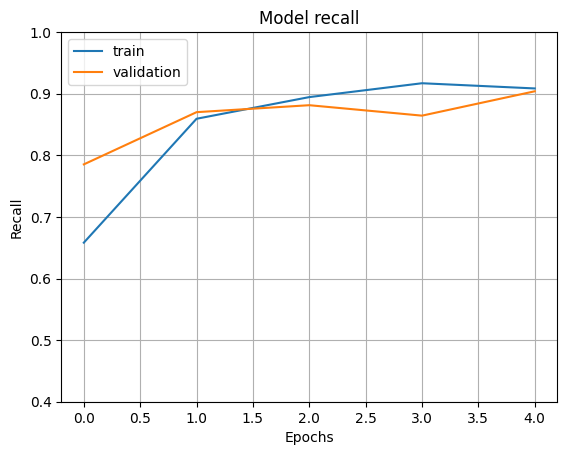

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

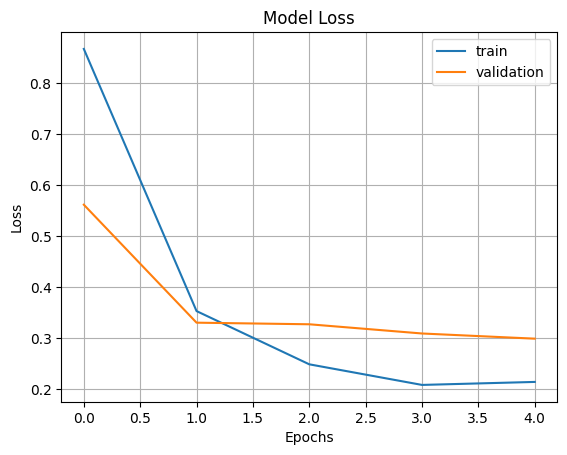

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

accuracy

In [ ]:
#accuracy
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
45/45 [==============================] - 189s 4s/step - loss: 0.6609 - accuracy: 0.7806 - val_loss: 0.4173 - val_accuracy: 0.8588
Epoch 2/5
45/45 [==============================] - 184s 4s/step - loss: 0.3913 - accuracy: 0.8383 - val_loss: 0.4854 - val_accuracy: 0.8249
Epoch 3/5
45/45 [==============================] - 172s 4s/step - loss: 0.2384 - accuracy: 0.9044 - val_loss: 0.3499 - val_accuracy: 0.8757
Epoch 4/5
45/45 [==============================] - 169s 4s/step - loss: 0.2315 - accuracy: 0.9184 - val_loss: 0.2953 - val_accuracy: 0.8870
Epoch 5/5
45/45 [==============================] - 174s 4s/step - loss: 0.2039 - accuracy: 0.9283 - val_loss: 0.3025 - val_accuracy: 0.8927


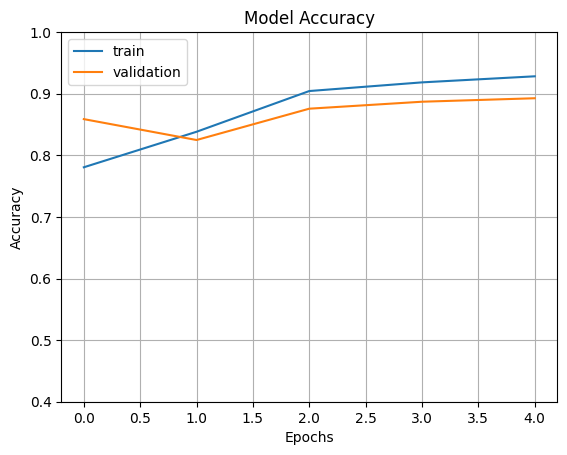

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

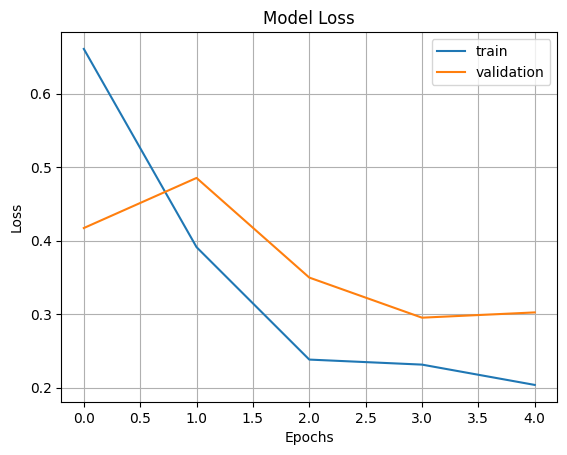

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

AUC

In [ ]:
#auc
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
45/45 [==============================] - 163s 4s/step - loss: 0.7513 - auc: 0.8789 - val_loss: 0.3617 - val_auc: 0.9634
Epoch 2/5
45/45 [==============================] - 150s 3s/step - loss: 0.3080 - auc: 0.9739 - val_loss: 0.3645 - val_auc: 0.9611
Epoch 3/5
45/45 [==============================] - 162s 4s/step - loss: 0.2519 - auc: 0.9821 - val_loss: 0.5759 - val_auc: 0.9322
Epoch 4/5
45/45 [==============================] - 150s 3s/step - loss: 0.3030 - auc: 0.9746 - val_loss: 0.3183 - val_auc: 0.9732
Epoch 5/5
45/45 [==============================] - 149s 3s/step - loss: 0.2278 - auc: 0.9855 - val_loss: 0.5122 - val_auc: 0.9486


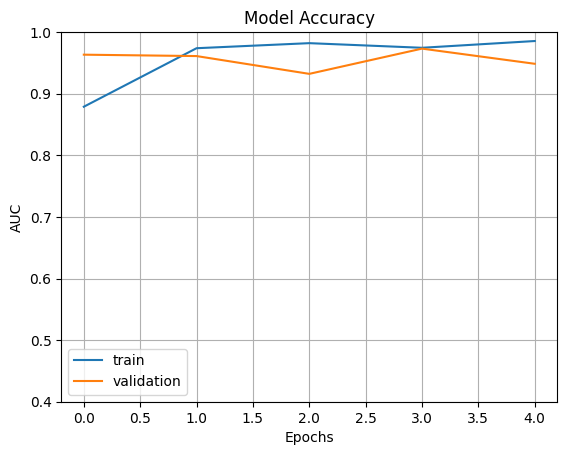

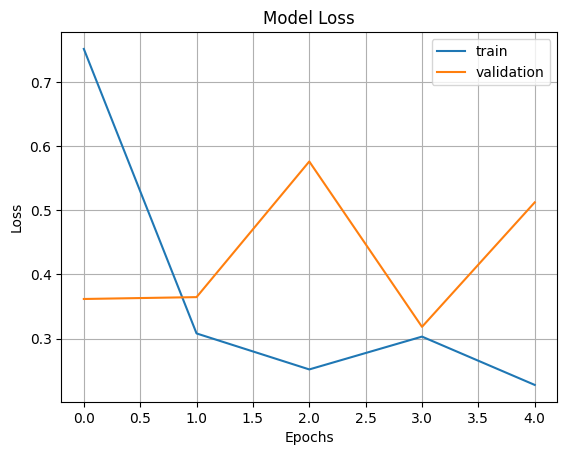

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#EfficientNetB0 Без аугментации 224

In [ ]:
efficientnet_model = Sequential()

# Загружаем предобученную EfficientNetB0
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'  # Используем Global Average Pooling
)

# Замораживаем веса предобученной модели
for layer in pretrained_model.layers:
    layer.trainable = False

# Добавляем EfficientNet в нашу модель
efficientnet_model.add(pretrained_model)

# Добавляем свои слои
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dense(3, activation='softmax'))  # 3 класса на выходе

# Компилируем модель
efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[keras.metrics.Recall()]
)

# Выводим информацию о модели
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 module_wrapper_9 (ModuleWr  (None, 1280)              0         
 apper)                                                          
                                                                 
 module_wrapper_10 (ModuleW  (None, 128)               163968    
 rapper)                                                         
                                                                 
 module_wrapper_11 (ModuleW  (None, 3)                 387       
 rapper)                                                         
                                                                 
Total params: 4213926 (16.07 MB)
Trainable params: 164

In [ ]:
epochs=15
history = efficientnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
45/45 [==============================] - 82s 2s/step - loss: 0.5711 - accuracy: 0.7651 - val_loss: 0.3546 - val_accuracy: 0.8644
Epoch 2/15
45/45 [==============================] - 68s 2s/step - loss: 0.2940 - accuracy: 0.8875 - val_loss: 0.3006 - val_accuracy: 0.8983
Epoch 3/15
45/45 [==============================] - 62s 1s/step - loss: 0.2439 - accuracy: 0.9058 - val_loss: 0.3375 - val_accuracy: 0.8644
Epoch 4/15
45/45 [==============================] - 72s 2s/step - loss: 0.2463 - accuracy: 0.9030 - val_loss: 0.2649 - val_accuracy: 0.9209
Epoch 5/15
45/45 [==============================] - 60s 1s/step - loss: 0.2092 - accuracy: 0.9241 - val_loss: 0.2886 - val_accuracy: 0.8983
Epoch 6/15
45/45 [==============================] - 70s 2s/step - loss: 0.2192 - accuracy: 0.9072 - val_loss: 0.4085 - val_accuracy: 0.8305
Epoch 7/15
45/45 [==============================] - 73s 2s/step - loss: 0.1799 - accuracy: 0.9339 - val_loss: 0.2635 - val_accuracy: 0.9153
Epoch 8/15
45/45 [==

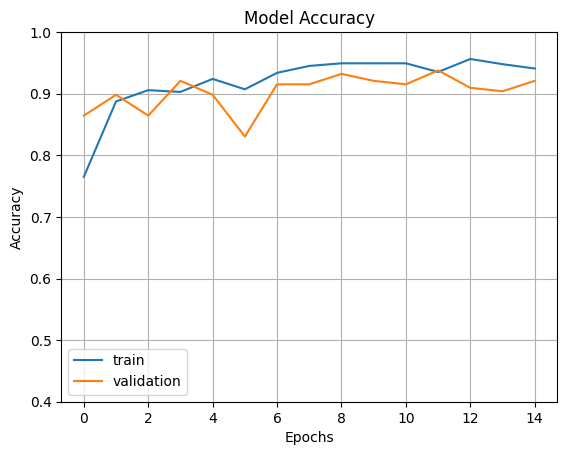

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

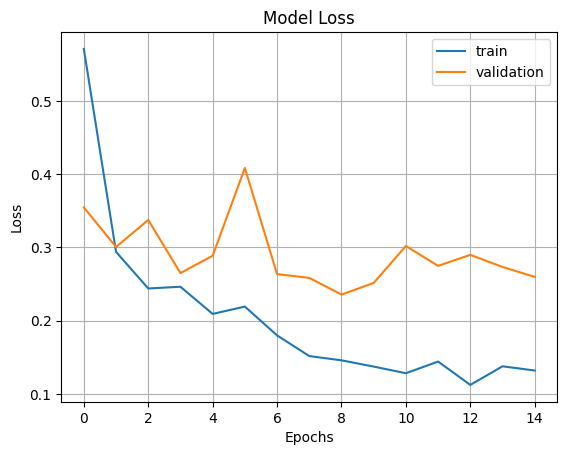

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

auc

In [ ]:
#auc keras.metrics.AUC()
epochs=5
history =  efficientnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/5
45/45 [==============================] - 74s 1s/step - loss: 0.4962 - auc_1: 0.9354 - val_loss: 0.4202 - val_auc_1: 0.9509
Epoch 2/5
45/45 [==============================] - 56s 1s/step - loss: 0.2849 - auc_1: 0.9778 - val_loss: 0.3571 - val_auc_1: 0.9649
Epoch 3/5
45/45 [==============================] - 57s 1s/step - loss: 0.2362 - auc_1: 0.9838 - val_loss: 0.2921 - val_auc_1: 0.9750
Epoch 4/5
45/45 [==============================] - 57s 1s/step - loss: 0.1947 - auc_1: 0.9902 - val_loss: 0.2766 - val_auc_1: 0.9771
Epoch 5/5
45/45 [==============================] - 65s 1s/step - loss: 0.1810 - auc_1: 0.9911 - val_loss: 0.2742 - val_auc_1: 0.9753


KeyError: 'auc'

<Figure size 640x480 with 0 Axes>

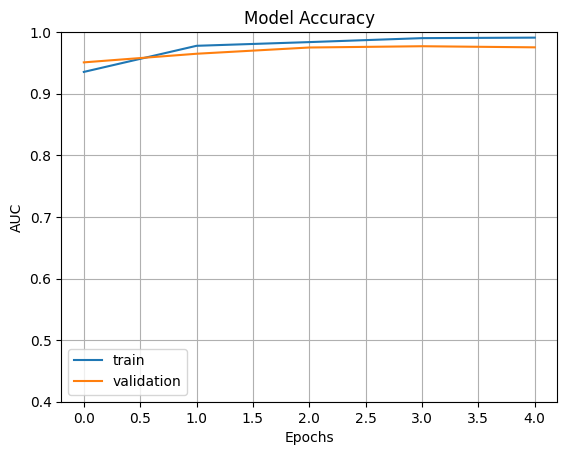

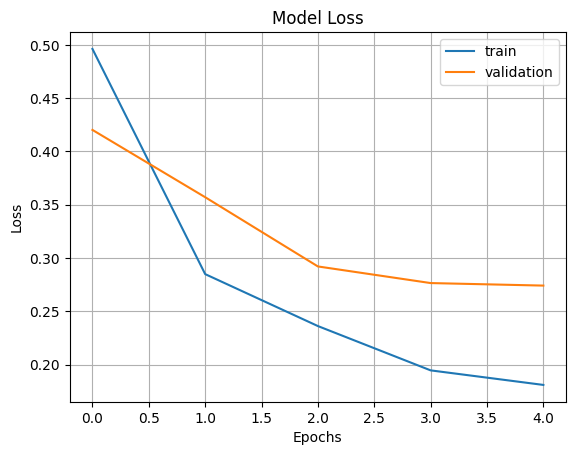

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

recall

In [ ]:
#recall keras.metrics.Recall()
epochs=5
history =  efficientnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
45/45 [==============================] - 80s 2s/step - loss: 0.5227 - recall_1: 0.7229 - val_loss: 0.4530 - val_recall_1: 0.7627
Epoch 2/5
45/45 [==============================] - 57s 1s/step - loss: 0.2831 - recall_1: 0.8734 - val_loss: 0.2949 - val_recall_1: 0.8983
Epoch 3/5
45/45 [==============================] - 54s 1s/step - loss: 0.2296 - recall_1: 0.9058 - val_loss: 0.2798 - val_recall_1: 0.8927
Epoch 4/5
45/45 [==============================] - 57s 1s/step - loss: 0.2043 - recall_1: 0.9198 - val_loss: 0.3026 - val_recall_1: 0.9040
Epoch 5/5
45/45 [==============================] - 55s 1s/step - loss: 0.2240 - recall_1: 0.9072 - val_loss: 0.2816 - val_recall_1: 0.9040


KeyError: 'recall'

<Figure size 640x480 with 0 Axes>

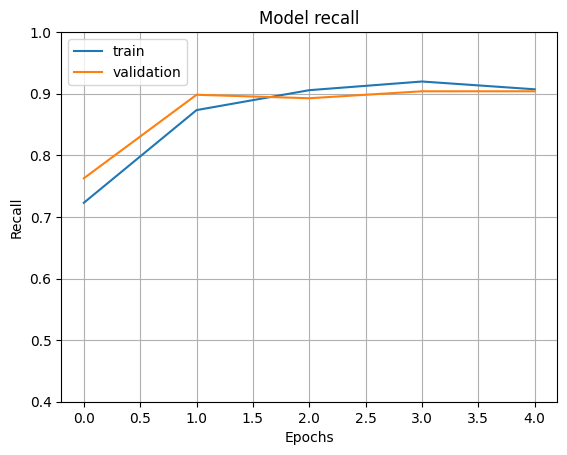

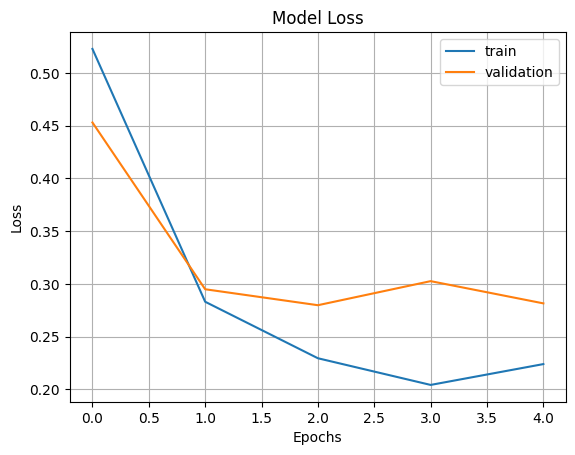

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# VGG16 без аугментации 224

In [ ]:
resnet_model_VGG16 = Sequential()

pretrained_model= tf.keras.applications.VGG16(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model_VGG16.add(pretrained_model)
resnet_model_VGG16.add(Flatten())
resnet_model_VGG16.add(Dense(128, activation='relu'))
resnet_model_VGG16.add(Dense(3, activation='softmax'))

resnet_model_VGG16.summary()
resnet_model_VGG16.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=[keras.metrics.Recall()])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 module_wrapper_15 (ModuleW  (None, 512)               0         
 rapper)                                                         
                                                                 
 module_wrapper_16 (ModuleW  (None, 128)               65664     
 rapper)                                                         
                                                                 
 module_wrapper_17 (ModuleW  (None, 3)                 387       
 rapper)                                                         
                                                                 
Total params: 14780739 (56.38 MB)
Trainable params: 66051 (258.01 KB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
epochs=25
history = resnet_model_VGG16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
45/45 [==============================] - 330s 7s/step - loss: 0.6322 - accuracy: 0.7539 - val_loss: 0.2779 - val_accuracy: 0.9040
Epoch 2/25
45/45 [==============================] - 307s 7s/step - loss: 0.2283 - accuracy: 0.9001 - val_loss: 0.3339 - val_accuracy: 0.8701
Epoch 3/25
45/45 [==============================] - 306s 7s/step - loss: 0.1858 - accuracy: 0.9184 - val_loss: 0.2445 - val_accuracy: 0.9096
Epoch 4/25
45/45 [==============================] - 279s 6s/step - loss: 0.1459 - accuracy: 0.9381 - val_loss: 0.3108 - val_accuracy: 0.9040
Epoch 5/25
45/45 [==============================] - 279s 6s/step - loss: 0.1604 - accuracy: 0.9367 - val_loss: 0.2861 - val_accuracy: 0.8983
Epoch 6/25
45/45 [==============================] - 273s 6s/step - loss: 0.1020 - accuracy: 0.9620 - val_loss: 0.2863 - val_accuracy: 0.8983
Epoch 7/25
45/45 [==============================] - 281s 6s/step - loss: 0.1225 - accuracy: 0.9592 - val_loss: 0.2712 - val_accuracy: 0.9266
Epoch 8/25
45

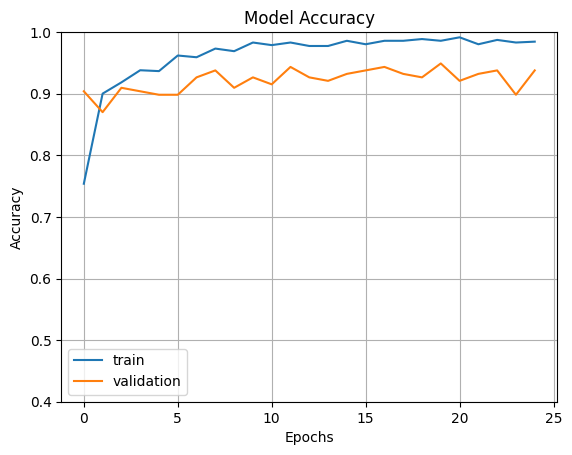

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

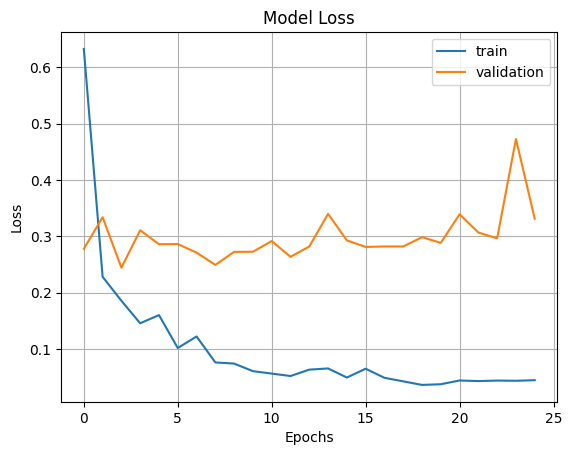

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

AUC

In [ ]:
#auc keras.metrics.AUC()
epochs=3
history =  resnet_model_VGG16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
45/45 [==============================] - 467s 10s/step - loss: 0.5893 - auc_2: 0.9271 - val_loss: 0.3970 - val_auc_2: 0.9631
Epoch 2/3
45/45 [==============================] - 460s 10s/step - loss: 0.2766 - auc_2: 0.9790 - val_loss: 0.2242 - val_auc_2: 0.9872
Epoch 3/3
45/45 [==============================] - 462s 10s/step - loss: 0.1795 - auc_2: 0.9908 - val_loss: 0.2319 - val_auc_2: 0.9872


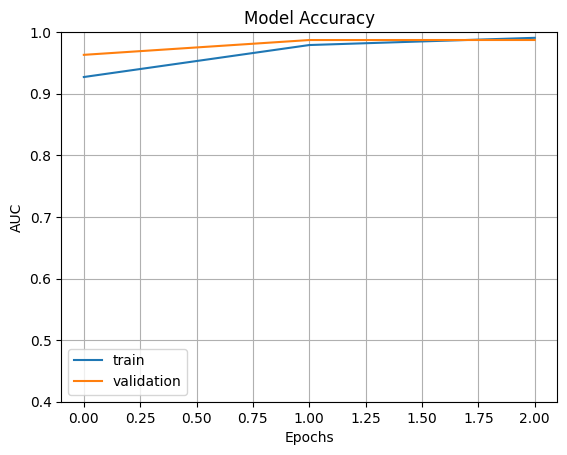

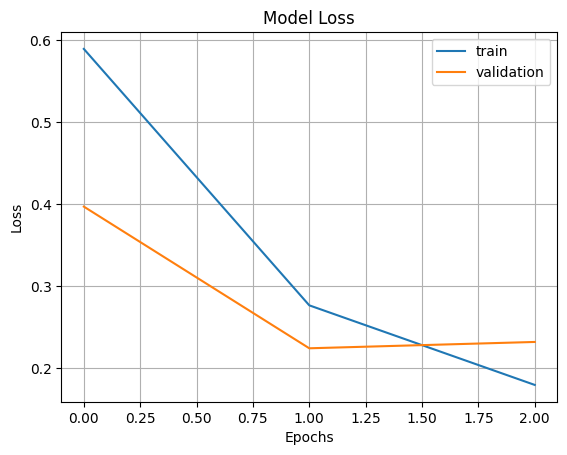

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['auc_2'])
plt.plot(history.history['val_auc_2'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Recall

In [ ]:
#recall keras.metrics.Recall()
epochs=5
history =  resnet_model_VGG16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
45/45 [==============================] - 472s 11s/step - loss: 0.8763 - recall_2: 0.7145 - val_loss: 0.2781 - val_recall_2: 0.8927
Epoch 2/5
45/45 [==============================] - 467s 10s/step - loss: 0.2580 - recall_2: 0.9030 - val_loss: 0.2640 - val_recall_2: 0.9040
Epoch 3/5
45/45 [==============================] - 463s 10s/step - loss: 0.2196 - recall_2: 0.9086 - val_loss: 0.2708 - val_recall_2: 0.8927
Epoch 4/5
45/45 [==============================] - 465s 10s/step - loss: 0.1553 - recall_2: 0.9339 - val_loss: 0.2186 - val_recall_2: 0.9266
Epoch 5/5
45/45 [==============================] - 463s 10s/step - loss: 0.1269 - recall_2: 0.9494 - val_loss: 0.2608 - val_recall_2: 0.9040


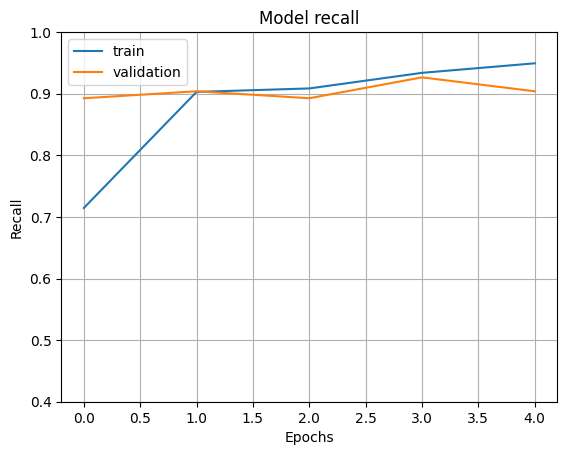

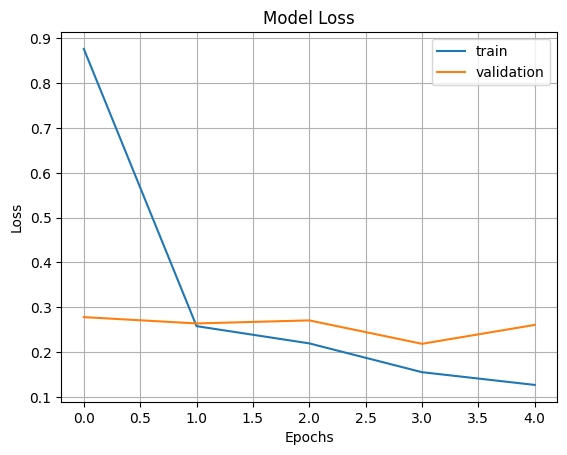

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# VGG19 без аугментации 224

In [ ]:
resnet_model_VGG19 = Sequential()

pretrained_model= tf.keras.applications.VGG19(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model_VGG16.add(pretrained_model)
resnet_model_VGG16.add(Flatten())
resnet_model_VGG16.add(Dense(128, activation='relu'))
resnet_model_VGG16.add(Dense(3, activation='softmax'))

resnet_model_VGG16.summary()
resnet_model_VGG16.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 module_wrapper_3 (ModuleWr  (None, 512)               0         
 apper)                                                          
                                                                 
 module_wrapper_4 (ModuleWr  (None, 128)               65664     
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 3)                 387       
 apper)                                                          
                                                                 
Total params: 14780739 (56.38 MB)
Trainable params: 66051 (258.01 KB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
epochs=25
history = resnet_model_VGG16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
45/45 [==============================] - 330s 7s/step - loss: 0.6322 - accuracy: 0.7539 - val_loss: 0.2779 - val_accuracy: 0.9040
Epoch 2/25
45/45 [==============================] - 307s 7s/step - loss: 0.2283 - accuracy: 0.9001 - val_loss: 0.3339 - val_accuracy: 0.8701
Epoch 3/25
45/45 [==============================] - 306s 7s/step - loss: 0.1858 - accuracy: 0.9184 - val_loss: 0.2445 - val_accuracy: 0.9096
Epoch 4/25
45/45 [==============================] - 279s 6s/step - loss: 0.1459 - accuracy: 0.9381 - val_loss: 0.3108 - val_accuracy: 0.9040
Epoch 5/25
45/45 [==============================] - 279s 6s/step - loss: 0.1604 - accuracy: 0.9367 - val_loss: 0.2861 - val_accuracy: 0.8983
Epoch 6/25
45/45 [==============================] - 273s 6s/step - loss: 0.1020 - accuracy: 0.9620 - val_loss: 0.2863 - val_accuracy: 0.8983
Epoch 7/25
45/45 [==============================] - 281s 6s/step - loss: 0.1225 - accuracy: 0.9592 - val_loss: 0.2712 - val_accuracy: 0.9266
Epoch 8/25
45

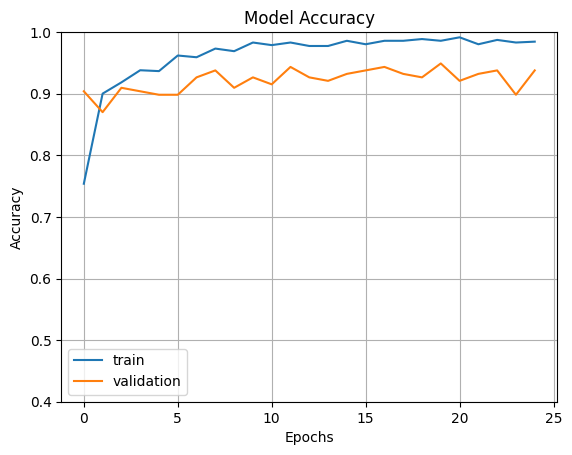

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

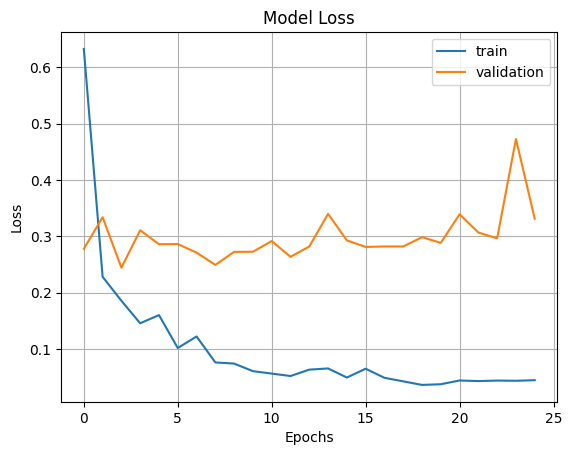

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()